# Analysis and plotting of RBD depletion ELISA data for HAARVI serum project

I used commercially-available magnetic beads conjugated to SARS-CoV-2 RBD to deplete serum of RBD-binding antibodies. 
Control pre-pandemic serum spiked with either an RBD-binding monoclonal antibody, rREGN10987 (at 5, 25, or 50 ug/mL) or an NTD-binding antibody (at 50 ug/mL) were also incubated with the RBD beads to get an estimate of how well the depletion works. 

The process of pulling down the RBD antibodies involved diluting the serum 1:4 (because I added 50 uL serum + 150 uL of bead suspension at 1mg/mL). 
In one condition that we will not plot here, I used 2x as many beads, and thus added 50 uL serum + 300 uL of bead suspension, so this was a 1:7 dilution of the initial serum.

The pre-depletion serum was also diluted 1:4 (or 1:7, as appropriate) in PBS + 0.05% BSA (the buffer the beads were suspended in). 

Depletions were performed overnight at 4C in Eppendorf tubes in a tube rotator. 

SARS-CoV-2 RBD and spike ELISAs were performed on these samples to verify the degree of RBD antibody depletion.

Here, I calculate the AUC for pre- vs. post-depletion samples and the fold-change in AUC. 

This is really just a test of whether the depletion worked at all and I don't think it is very useful for anything beyond that (see notes at the end!).

### Set up Analysis

Import same packages as from children serology notebook.

In [22]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import numpy
import pandas as pd
from plotnine import *
import seaborn

import sklearn
import scipy.stats

import yaml

In [23]:
warnings.simplefilter('ignore')

In [24]:
cbPalette = ("#999999", "#E69F00", "#56B4E9", "#009E73",
             "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Read config file.

In [25]:
with open('rbd_absorption_config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [26]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

In [27]:
resultsdir='ELISA_results'
os.makedirs(resultsdir, exist_ok=True)

In [28]:
pd.options.display.max_rows = 100

## Titration ELISAs

### Read ELISA Titration Data

I first manipulated the data in R and made a new CSV file that we can read in now. Here I:
* Concatenate files together (if there are multiple)
* Remove samples as indicated in config file
* Replace serum names with `display_names`
* Change `dilution` to `dilution factor`
* Take 1/dilution factor to get the dilution (i.e., a 1:100 dilution is `dilution_factor==100` and `dilution==0.01`

In [29]:
titration_df = pd.DataFrame() # create empty data frame
elisa_samples_ignore = config['elisa_samples_ignore']

for f in config['elisa_input_files']:
    df = pd.read_csv(f)
    titration_df = titration_df.append(df)

titration_df = (titration_df
        .query('serum not in @elisa_samples_ignore'))

titration_df = (titration_df
        .replace({'serum' : config['display_names']})
        .rename(columns={'dilution':'dilution_factor'})
        .assign(depleted= pd.Categorical(titration_df['depleted'], categories=['pre', 'post'], ordered=True),
                dilution=lambda x: 1/x['dilution_factor'],
                ab_serum = titration_df.apply(lambda x: 'antibody' 
                                                   if x['dilution_or_ugpermL']=="ugpermL" 
                                                   else 'serum',
                                                   axis=1)
               )
       )

display(titration_df.head())  # display first few lines

,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,dilution,ab_serum
0,13_d15,pre,RBD,dilution,201020,100.0,3.4429,NaN,1,4.605170,0.010000,serum
1,13_d15,pre,RBD,dilution,201020,300.0,2.6471,NaN,1,5.703782,0.003333,serum
2,13_d15,pre,RBD,dilution,201020,900.0,1.8843,NaN,1,6.802395,0.001111,serum
3,13_d15,pre,RBD,dilution,201020,2700.0,0.9066,NaN,1,7.901007,0.000370,serum
4,13_d15,pre,RBD,dilution,201020,8100.0,0.2911,NaN,1,8.999619,0.000123,serum


In [30]:
titration_df.query('serum=="23_d45 (re-depleted)"')

,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,dilution,ab_serum


### Plot ELISA data pre- and post-depletion with RBD beads

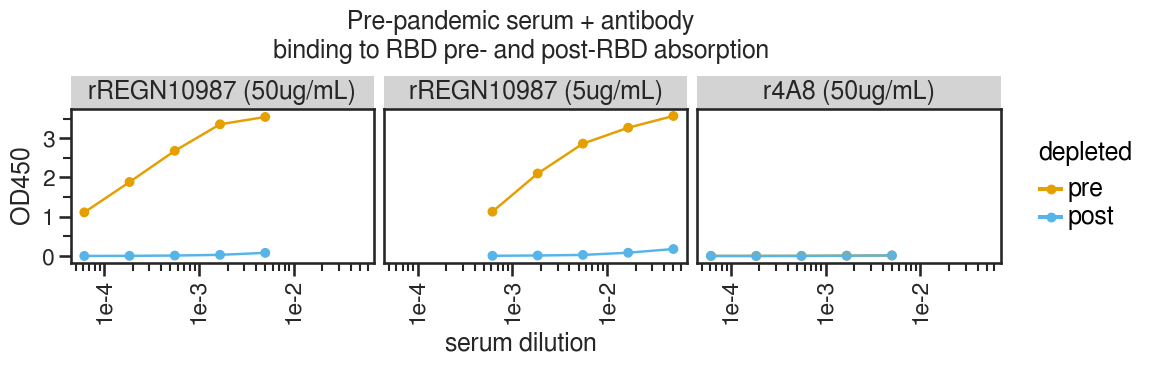

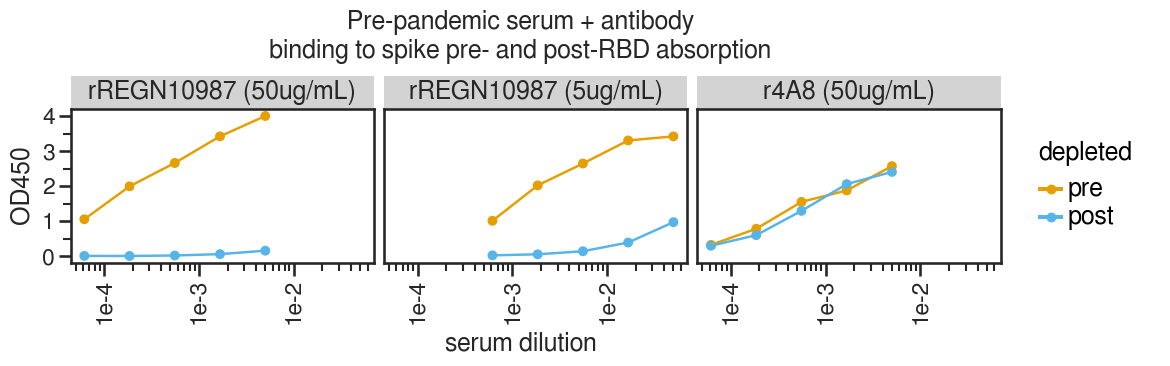

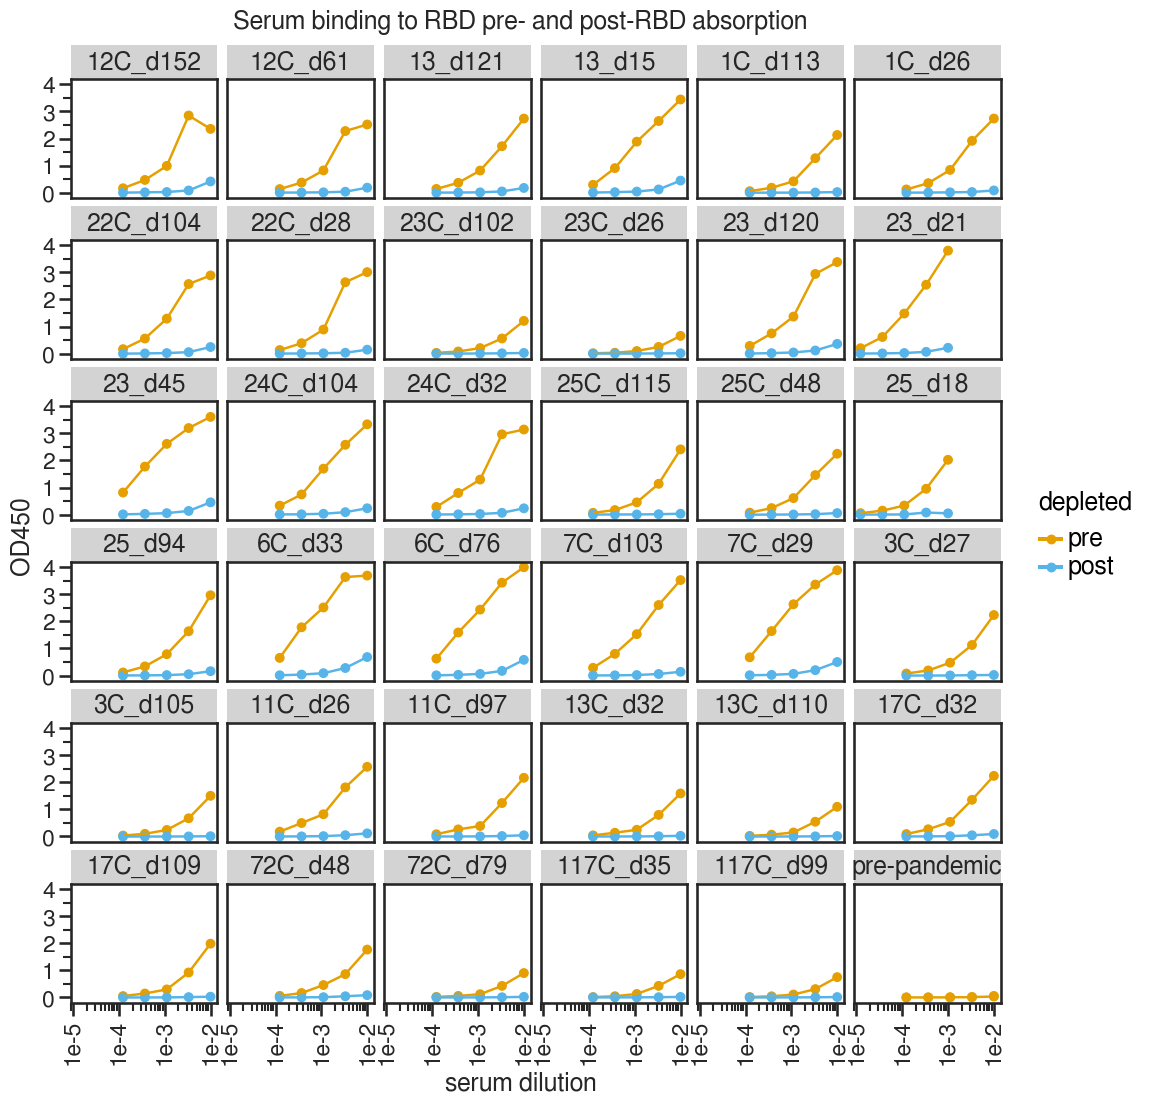

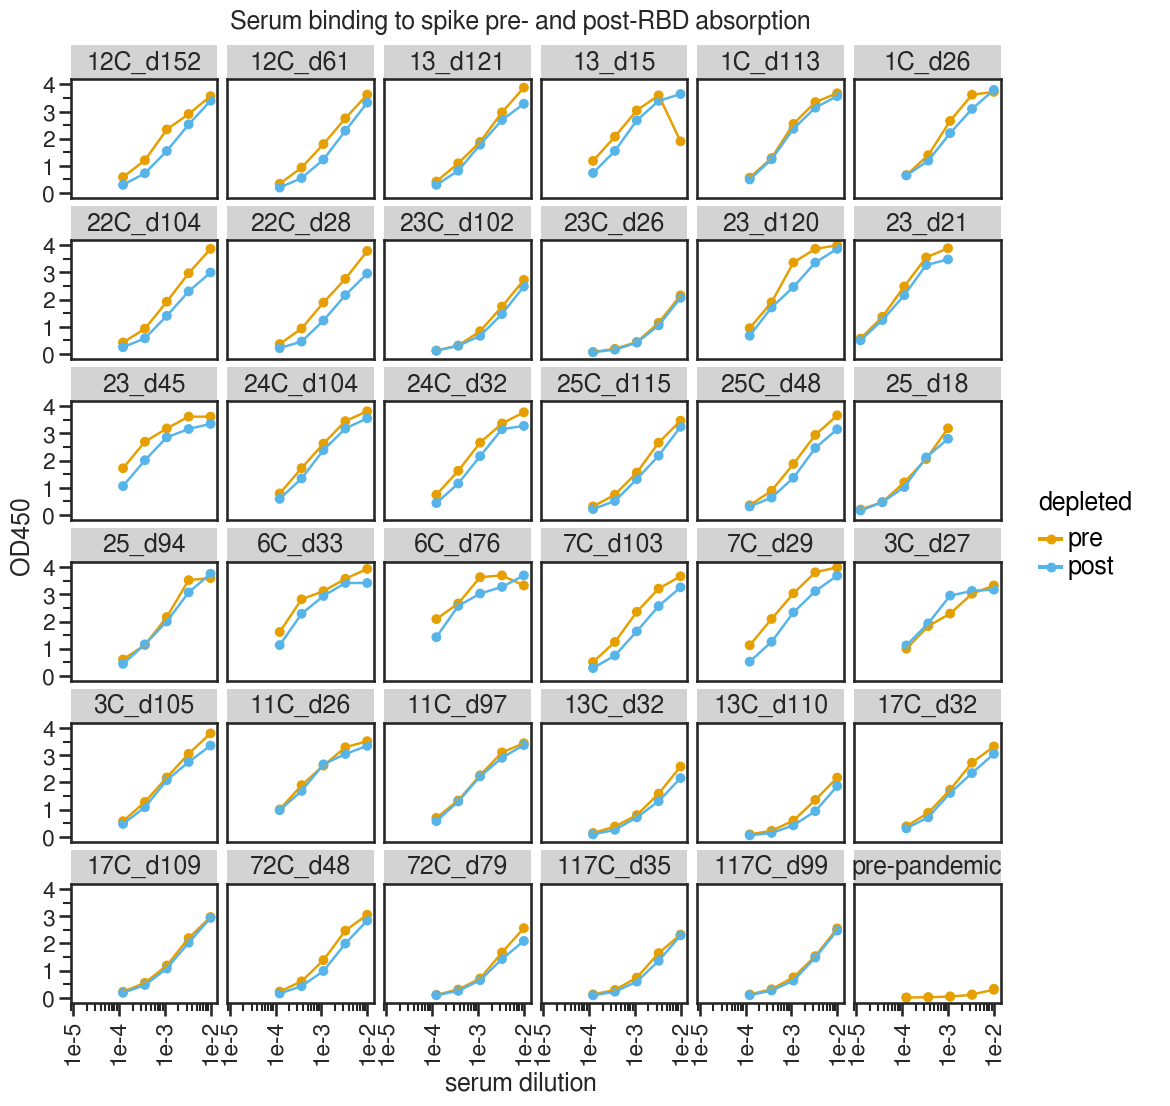

In [31]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    for lig in ['RBD', 'spike']:
        df = titration_df.query('ligand==@lig & serum in @antibody_order')
        df['serum'] = pd.Categorical(df['serum'], categories=antibody_order, ordered=True)
        
        nconditions = df['serum'].nunique()
        ncol = 6
        nrow = math.ceil(nconditions / ncol)
        
        if list(group.keys())[0] == 'antibody_controls':
            title = "Pre-pandemic serum + antibody"\
                    f"\nbinding to {lig} pre- and post-RBD absorption"
            
        else:
            title = f"Serum binding to {lig} pre- and post-RBD absorption"
        
        p = (
            ggplot(df,
                   aes('dilution', 
                       'OD450', 
                       group='depleted', 
                       color='depleted')) +
            geom_point(size=3) +
            geom_line(aes(group='depleted'), size=1) +
            scale_x_log10(name='serum dilution') +
            facet_wrap('~ serum', ncol=ncol) +
            ggtitle(title) +
            theme(figure_size=(2 * ncol, 2 * nrow),
                  axis_text_x=element_text(angle=90),
                  subplots_adjust={'hspace':0.35}) +
            scale_color_manual(values=cbPalette[1:]) 
            )

        _ = p.draw()
        p.save(f'./{resultsdir}/{list(group.keys())[0]}_{lig}_depletion.png')

### Plot spike and RBD ELISA curves on the same graph 

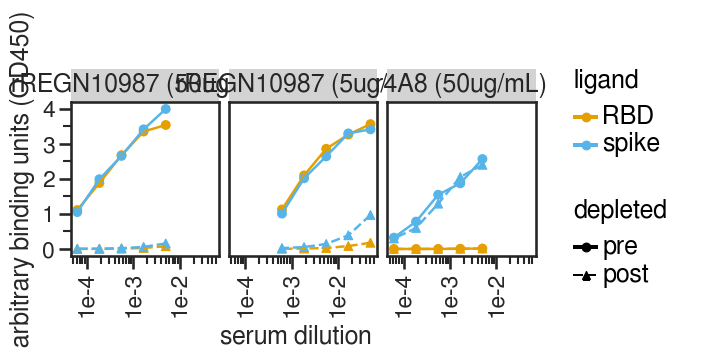

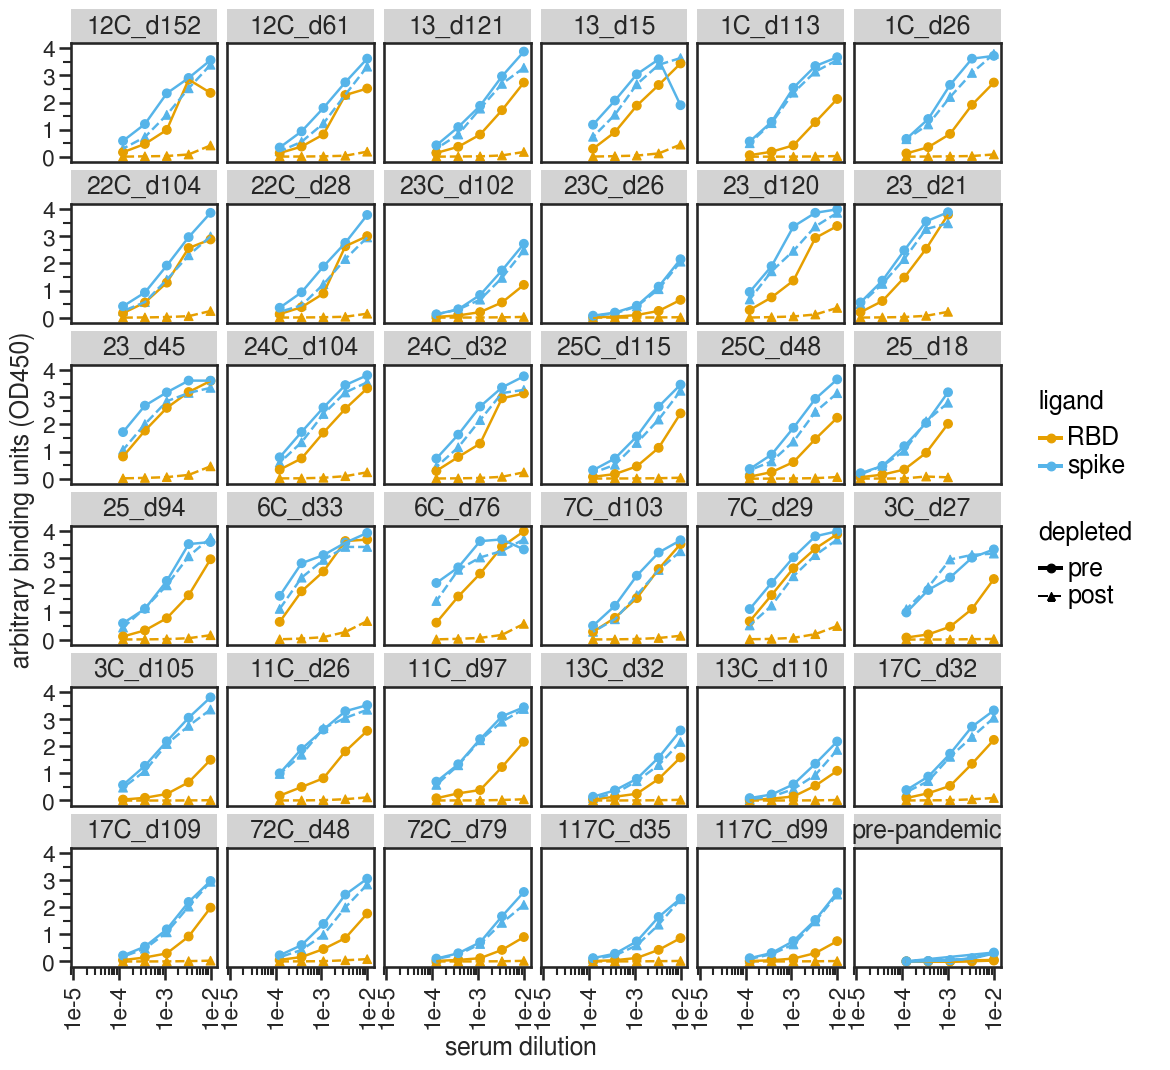

In [32]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    #for lig in ['RBD', 'spike']:
    df = titration_df.query('serum in @antibody_order')
    df['serum'] = pd.Categorical(df['serum'], categories=antibody_order, ordered=True)

    nconditions = df['serum'].nunique()
    ncol = numpy.minimum(6, nconditions)
    nrow = math.ceil(nconditions / ncol)

    p = (
        ggplot(df,
               aes('dilution', 
                   'OD450', 
                   color='ligand',
                   shape='depleted')) +
        geom_point(size=3) +
        geom_path(aes(color='ligand', linetype='depleted'), size=1) +
        scale_x_log10(name='serum dilution') +
        facet_wrap('~ serum', ncol=ncol) +
        theme(figure_size=(2 * ncol, 2 * nrow),
              axis_text_x=element_text(angle=90),
              subplots_adjust={'hspace':0.35}) +
        scale_color_manual(values=cbPalette[1:]) +
        ylab('arbitrary binding units (OD450)')
        )

    _ = p.draw()
    p.save(f'./{resultsdir}/{list(group.keys())[0]}_depletion.png')

### Calculate area under curves (AUCs)

Calculate area under curve (AUC) for each ELISA. Note that these are areas calculated using a trapezoidal rule between the min and max dilutions with the x-axis being the natural log dilution factor.

The utility of these calculations pre-supposes that each sample has the same dilutions. 

**THIS IS NOT THE CASE FOR OUR DATA**

However, this is the case for the pre- and post-depletion samples for each seurm, which is what really matters. 

In [33]:
auc_df = (
    titration_df
    .query('ab_serum=="serum"')
    .groupby(['serum',
             'depleted',
             'ligand',
             'dilution_or_ugpermL',
             'ab_serum',
             'date',
             'replicate',
             ])
    .apply(lambda g: sklearn.metrics.auc(g['log_dilution'], g['OD450']))
    .rename('AUC')
    .reset_index()
    )

auc_df.head().round(3)

,serum,depleted,ligand,dilution_or_ugpermL,ab_serum,date,replicate,AUC
0,117C_d35,pre,RBD,dilution,serum,201029,1,1.141
1,117C_d35,pre,spike,dilution,serum,201029,1,4.277
2,117C_d35,post,RBD,dilution,serum,201029,1,0.025
3,117C_d35,post,spike,dilution,serum,201029,1,3.696
4,117C_d99,pre,RBD,dilution,serum,201108,1,0.921


### Get mean AUC for "background sample": the pre-pandemic 2017-2018 serum pool

In [34]:
elisa_background_sample = config['elisa_background_sample']
background = (auc_df
              .query('serum==@elisa_background_sample')
              .groupby(['ligand'])
              .aggregate({'AUC' : 'mean'})
              .reset_index()
             )

background

,ligand,AUC
0,RBD,0.041994
1,spike,0.364025


### Look at AUC pre- vs. post-depletion for each individual (same data as above, but with connecting lines)

The orange dashed line indicates the AUC of the pre-pandemic serum (2017-2018 pooled serum), which was not RBD depleted. 

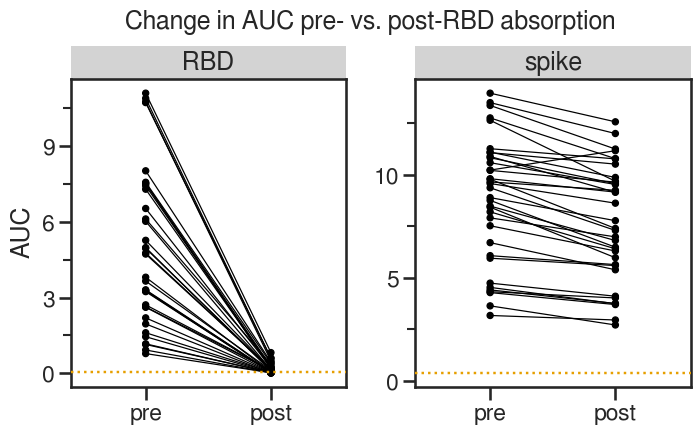

In [35]:
AUC_lines = (ggplot(auc_df
                    .query('serum!=@elisa_background_sample'), 
                    aes(x='depleted', y='AUC', group='serum')) +
                  geom_point(size=2) +
                  geom_line() +
                  facet_wrap('~ ligand', scales='free_y') +
                  theme(axis_text_x=element_text(angle=0, vjust=1, hjust=0.5),
                        figure_size=(8, 4), subplots_adjust={'wspace':0.25},
                        legend_entry_spacing=14) +
                  ylab('AUC') +
                  xlab('') +
                  ggtitle('Change in AUC pre- vs. post-RBD absorption') +
             
             # add line for background defined by 2017-2018 serum pool
                  geom_hline(data=background,
                             mapping=aes(yintercept='AUC'),
                             color=cbPalette[1],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            ) 
                 )

_ = AUC_lines.draw()
AUC_lines.save(f'./{resultsdir}/AUC_lines.png')

### Calculate fold-change AUC pre- vs. post-depletion.

We can also sort these values based on fold-change of spike AUC, as we probably expect the most RBD-targeting samples to have the greatest reduction in spike ELISA signal. 

In [36]:
foldchange_auc = (
    auc_df
    .assign(depleted=lambda x: x.depleted.astype(str)) #.columns = df1.columns.astype(list)
    .pivot_table(values='AUC', index=['serum', 'ligand'], columns=['depleted'])
    .reset_index()
    .rename(columns={'post': 'post-depletion_auc', 'pre': 'pre-depletion_auc'})
    .assign(fold_change=lambda x: x['post-depletion_auc'] / x['pre-depletion_auc'],
            reciprocal_fold_change=lambda x: 1/x['fold_change']
           )
    )

foldchange_auc.to_csv(f'{resultsdir}/rbd_depletion_foldchange_auc.csv', index=False)
foldchange_auc.head()

depleted,serum,ligand,post-depletion_auc,pre-depletion_auc,fold_change,reciprocal_fold_change
0,117C_d35,RBD,0.025103,1.140799,0.022005,45.444206
1,117C_d35,spike,3.695842,4.277117,0.864096,1.157278
2,117C_d99,RBD,0.015216,0.921406,0.016514,60.555965
3,117C_d99,spike,4.016801,4.319359,0.929953,1.075323
4,11C_d26,RBD,0.132657,4.953588,0.026780,37.341201


In [37]:
foldchange_wider = (
    foldchange_auc
    .pivot_table(values='reciprocal_fold_change', index=['serum'], columns=['ligand'])
    .reset_index()
    )

foldchange_wider.sort_values(by=['spike'], ascending=False)

ligand,serum,RBD,spike
15,22C_d28,44.410284,1.410935
14,22C_d104,29.454298,1.350778
6,13C_d110,118.197275,1.342885
33,7C_d103,45.257691,1.323709
34,7C_d29,18.413495,1.305718
4,12C_d152,17.168851,1.283885
5,12C_d61,32.985213,1.279916
24,25C_d48,82.590000,1.245489
31,72C_d48,24.394495,1.244637
7,13C_d32,88.240640,1.211984


From a quick by-eye comparison between this sorted list (by fold-change spike AUC) and the fold-change IC50 in neutralizzation assays, there is little relationship between these two. 
So I am not going to worry about this anymore. 
For reference, the samples that had the greatest reduction in NT50 (or increase in IC50) following depletion were:
1. 24C_d104
2. 25_d18
3. 22C_d104
4. 1C_d26
5. 24C_d32
6. 25_d94
7. 1C_d113

For ELISAs, we see a very small decrease in spike AUC following depletion for 24C and 25 samples in particular.
So, I am not going to worry about the ELISA signal anymore and just take the ELISAs as a test of whether the depletion worked or not. 

In [38]:
!jupyter nbconvert elisa_auc.ipynb --to html

[NbConvertApp] Converting notebook elisa_auc.ipynb to html
[NbConvertApp] Writing 1542159 bytes to elisa_auc.html
